In [1]:
#pip install imblearn


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import joblib
from joblib import load

In [3]:

# %cd ..
# %cd MADS/Capstone/MADS-Capstone
%pwd

'c:\\Users\\ericm\\OneDrive\\Documents\\MADS\\Capstone\\MADS-Capstone'

In [4]:
df = pd.read_csv("cleaned_data.csv")

# take random sample of dataframe to reduce size
df = df.sample(n=200000, random_state=1)

# Drop discharge variable which was not dropped during preprocessing
df = df.drop(["YEAR_OF_DISCHARGE"])

df.head()

,AGE,GENDER,RACE,MARITAL_STATUS,EDUCATION,EMPLOYMENT_AT_ADMISSION,LIVING_ARRANGEMENT_AT_ADMISSION,ARRESTS_IN_30_DAYS_PRIOR_TO_ADMISSION,SERVICES_AT_ADMISSION,REASON_FOR_DISCHARGE,...,PRIMARY_SUBSTANCE_ABUSE,FREQUENCY_OF_USE,AGE_AT_FIRST_USE,ALCOHOL_OR_DRUG_ABUSE,DSM_DIAGNOSIS,PSYCHIATRIC_PROBLEM,HEALTH_INSURANCE,PRIMARY_PAYMENT_METHOD,FREQUENCY_OF_SELF_HELP_ATTENDANCE,STATE
1157146,30-34,Male,White,Never married,"1-3 years of college, university, or vocationa...",Unemployed,Dependent living,None,"Detox, 24-hour, free-standing residential",Treatment completed,...,Alcohol,Daily use,21-24 years,Alcohol only,Alcohol dependence,No,None,Not known,No attendance,Nevada
2545484,25-29,Male,White,Never married,Grade 12 (or GED),Unemployed,Homeless,Two or more times,"Rehab/residential, long term (more than 30 days)",Treatment completed,...,Marijuana/hashish,No use in the past month,12-14 years,Alcohol and other drugs,Not known,Not known,Not known,Not known,No attendance,Minnesota
4316223,50-54,Male,White,Now Married,Grade 12 (or GED),Full time,Independent living,None,"Ambulatory, non-intensive outpatient",Treatment completed,...,Alcohol,Daily use,12-14 years,Alcohol only,Alcohol dependence,No,Not known,Not known,No attendance,North Carolina
4081170,25-29,Male,Black or African American,Never married,Grades 9 to 11,Not in labor force,Dependent living,None,"Rehab/residential, long term (more than 30 days)",Treatment completed,...,Heroin,Daily use,18-20 years,Other drugs only,Opioid dependence,No,Medicaid,Medicaid,No attendance,Maryland
972718,55-64,Male,Black or African American,Now Married,Grade 12 (or GED),Unemployed,Not known,None,"Ambulatory, intensive outpatient",Transferred to another treatment program or fa...,...,Heroin,Daily use,25-29 years,Other drugs only,Opioid dependence,No,Not known,Not known,4-7 times in the past month,North Carolina


In [5]:
print(df.columns)
print(df.shape)

Index(['AGE', 'GENDER', 'RACE', 'MARITAL_STATUS', 'EDUCATION',
       'EMPLOYMENT_AT_ADMISSION', 'LIVING_ARRANGEMENT_AT_ADMISSION',
       'ARRESTS_IN_30_DAYS_PRIOR_TO_ADMISSION', 'SERVICES_AT_ADMISSION',
       'REASON_FOR_DISCHARGE', 'PRIMARY_SOURCE_OF_REFERRAL',
       'PRIOR_TREATMENT_EPISODES', 'PRIMARY_SUBSTANCE_ABUSE',
       'FREQUENCY_OF_USE', 'AGE_AT_FIRST_USE', 'ALCOHOL_OR_DRUG_ABUSE',
       'DSM_DIAGNOSIS', 'PSYCHIATRIC_PROBLEM', 'HEALTH_INSURANCE',
       'PRIMARY_PAYMENT_METHOD', 'FREQUENCY_OF_SELF_HELP_ATTENDANCE', 'STATE'],
      dtype='object')
(200000, 22)


## Feature Engineering

In [6]:
print(df['REASON_FOR_DISCHARGE'].value_counts(), '\n')
print(df['SERVICES_AT_ADMISSION'].value_counts(), '\n')
print(df['PRIOR_TREATMENT_EPISODES'].value_counts())

Treatment completed                                     83354
Dropped out of treatment                                49998
Transferred to another treatment program or facility    42922
Terminated by facility                                  11480
Other                                                    8581
Incarcerated                                             3179
Death                                                     486
Name: REASON_FOR_DISCHARGE, dtype: int64 

Ambulatory, non-intensive outpatient                100682
Detox, 24-hour, free-standing residential            29735
Ambulatory, intensive outpatient                     27010
Rehab/residential, short term (30 days or fewer)     20446
Rehab/residential, long term (more than 30 days)     15037
Detox, 24-hour, hospital inpatient                    4977
Ambulatory, detoxification                            1609
Rehab/residential, hospital (non-detox)                504
Name: SERVICES_AT_ADMISSION, dtype: int64 

One or 

In [7]:
df = df[df['REASON_FOR_DISCHARGE'] != 'Transferred to another treatment program or facility']

In [8]:
# Create target variable. If the patient completed treatment and had no prior treatment episodes, they are considered a success. Otherwise, they are considered a failure.
df['SUCCESSFUL_TREATMENT'] = df.apply(lambda row: 1 if row['REASON_FOR_DISCHARGE'] == 'Treatment completed' and row['PRIOR_TREATMENT_EPISODES'] == "No prior treatment episode" else 0, axis=1)

print(df['SUCCESSFUL_TREATMENT'].value_counts())

0    129374
1     27704
Name: SUCCESSFUL_TREATMENT, dtype: int64


## Modeling

### Initial evaluation/model baselines

In [9]:
df_one_hot = pd.get_dummies(df)
df_one_hot.shape

for col in df_one_hot.columns:
    print(col)

SUCCESSFUL_TREATMENT
AGE_12-14
AGE_15-17
AGE_18-20
AGE_21-24
AGE_25-29
AGE_30-34
AGE_35-39
AGE_40-44
AGE_45-49
AGE_50-54
AGE_55-64
AGE_65+
GENDER_Female
GENDER_Male
GENDER_Not known
RACE_Alaskan Native
RACE_American Indian
RACE_Asian
RACE_Asian or Pacific Islander
RACE_Black or African American
RACE_Native Hawaiian or Other Pacific Islander
RACE_Not known
RACE_Other single race
RACE_Two or more races
RACE_White
MARITAL_STATUS_Divorced, widowed
MARITAL_STATUS_Never married
MARITAL_STATUS_Not known
MARITAL_STATUS_Now Married
MARITAL_STATUS_Separated
EDUCATION_1-3 years of college, university, or vocational school
EDUCATION_4 years of college, university, BA/BS, some postgraduate study, or more
EDUCATION_Grade 12 (or GED)
EDUCATION_Grades 9 to 11
EDUCATION_Less than one school grade, no schooling, nursery school, or kindergarten to Grade 8
EDUCATION_Not known
EMPLOYMENT_AT_ADMISSION_Full time
EMPLOYMENT_AT_ADMISSION_Not in labor force
EMPLOYMENT_AT_ADMISSION_Not known
EMPLOYMENT_AT_ADMISS

In [10]:
target = df['SUCCESSFUL_TREATMENT']
features = df.drop(['REASON_FOR_DISCHARGE', 'PRIOR_TREATMENT_EPISODES', 'SUCCESSFUL_TREATMENT'], axis=1)
features_one_hot = pd.get_dummies(features)

X_train, X_test, y_train, y_test = train_test_split(features_one_hot, target, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(125662, 193) (31416, 193) (125662,) (31416,)


In [11]:
# for col in X_train.columns:
#     print(col)

In [12]:
# models_to_train = {
#     "naive_bayes": GaussianNB(),
#     "logistic_regression": LogisticRegression(max_iter=1000),
#     "random_forest": RandomForestClassifier()
# }

# for model_name, model in models_to_train.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"Accuracy score for {model_name}: {accuracy_score(y_test, y_pred)}")
#     print(f"f1 score for {model_name}: {f1_score(y_test, y_pred)}", '\n')

## Balance the data 

In [13]:
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print(y_train_res.value_counts())

0    103527
1    103527
Name: SUCCESSFUL_TREATMENT, dtype: int64


In [14]:
print(X_train_res.shape, y_train_res.shape)

(207054, 193) (207054,)


In [15]:
for col in X_train_res.columns:
    print(col)

AGE_12-14
AGE_15-17
AGE_18-20
AGE_21-24
AGE_25-29
AGE_30-34
AGE_35-39
AGE_40-44
AGE_45-49
AGE_50-54
AGE_55-64
AGE_65+
GENDER_Female
GENDER_Male
GENDER_Not known
RACE_Alaskan Native
RACE_American Indian
RACE_Asian
RACE_Asian or Pacific Islander
RACE_Black or African American
RACE_Native Hawaiian or Other Pacific Islander
RACE_Not known
RACE_Other single race
RACE_Two or more races
RACE_White
MARITAL_STATUS_Divorced, widowed
MARITAL_STATUS_Never married
MARITAL_STATUS_Not known
MARITAL_STATUS_Now Married
MARITAL_STATUS_Separated
EDUCATION_1-3 years of college, university, or vocational school
EDUCATION_4 years of college, university, BA/BS, some postgraduate study, or more
EDUCATION_Grade 12 (or GED)
EDUCATION_Grades 9 to 11
EDUCATION_Less than one school grade, no schooling, nursery school, or kindergarten to Grade 8
EDUCATION_Not known
EMPLOYMENT_AT_ADMISSION_Full time
EMPLOYMENT_AT_ADMISSION_Not in labor force
EMPLOYMENT_AT_ADMISSION_Not known
EMPLOYMENT_AT_ADMISSION_Part time
EMPLOYM

In [26]:
# for model_name, model in models_to_train.items():
#     model.fit(X_train_res, y_train_res)
#     y_pred = model.predict(X_test)
#     print(f"Accuracy score for {model_name}: {accuracy_score(y_test, y_pred)}")
#     print(f"Confusion matrix: \n{confusion_matrix(y_test, y_pred)}\n")

## Tuning

In [27]:
# Define the parameter grid
param_grid = {
    'n_estimators': [500], #100, 200, 400, 
    'max_depth': [10], #5, 15, None
    'min_samples_split': [2], #2,10
    'min_samples_leaf': [2] #1,4
}

# Define model
rf = RandomForestClassifier()

# Grid
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Save the model
joblib.dump(grid_search.best_estimator_, 'best_random_forest.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# %cd ..
# %cd MADS-CAPSTONE

c:\Users\ericm\OneDrive\Documents\MADS\Capstone
c:\Users\ericm\OneDrive\Documents\MADS\Capstone\MADS-CAPSTONE


In [20]:
%pwd

'c:\\Users\\ericm\\OneDrive\\Documents\\MADS\\Capstone\\MADS-Capstone'

In [16]:
with open('best_random_forest.pkl', 'rb') as file:
    model = load(file)

y_pred = model.predict(X_test)
print(f"Accuracy score for random forest: {accuracy_score(y_test, y_pred)}")

Accuracy score for random forest: 0.7083333333333334


In [19]:
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
[3.69654642e-04 4.71153574e-03 7.72795996e-04 8.77798430e-04
 7.83124572e-04 7.74991116e-04 8.20968197e-04 5.73426447e-04
 5.64445770e-04 1.02892466e-03 6.11511562e-04 3.41123790e-04
 9.93888890e-04 1.04004973e-03 1.88157198e-06 7.05221070e-05
 4.25908266e-04 3.10073025e-04 1.59878444e-05 1.64259781e-03
 2.03504157e-04 2.73705897e-03 8.35642223e-04 3.92441082e-04
 1.41021666e-03 1.10332450e-03 4.23125053e-03 1.62336052e-02
 1.91018802e-03 4.23000254e-04 9.21546378e-04 6.34066387e-04
 1.76127444e-03 1.10875482e-03 9.82749730e-04 2.98065314e-02
 9.78518009e-03 4.61500366e-03 9.26913473e-03 6.33727211e-04

## Feature Importances

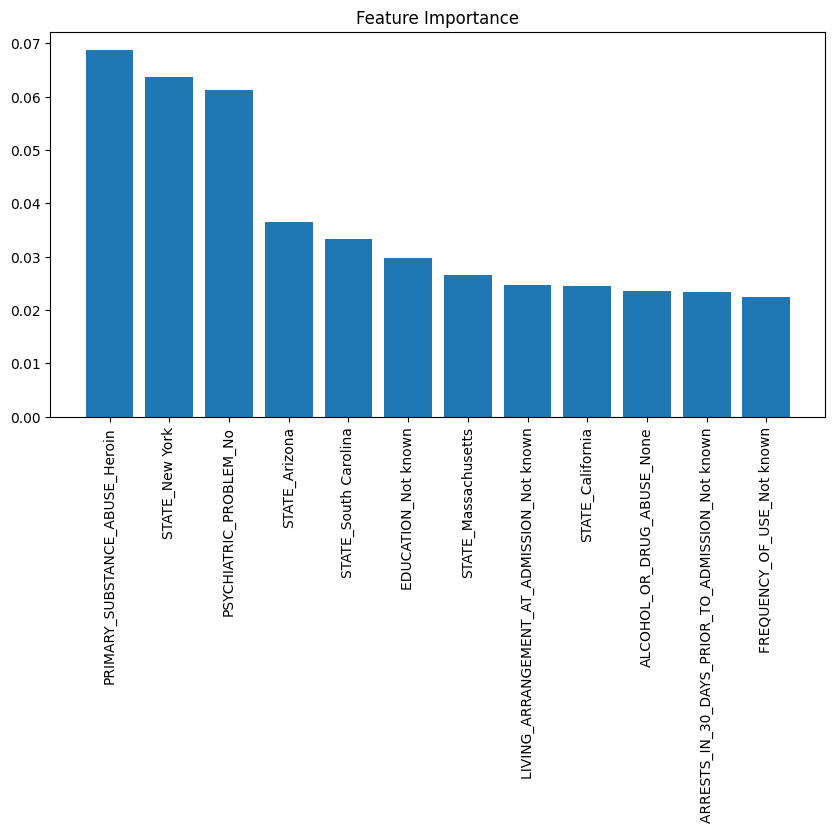

In [34]:
from joblib import load
import pickle
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# load model
with open('best_random_forest.pkl', 'rb') as file:
    model = load(file)

# extract feature importances from model
importances = model.feature_importances_

# sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]


# number of features to display
num_features = 12

# create plot
plt.figure(figsize=(10,5))  # Adjust as needed

# create plot title
plt.title("Feature Importance")

# add bars for top num_features
plt.bar(range(num_features), importances[indices[:num_features]])

# add feature names as x-axis labels
plt.xticks(range(num_features), [names[i] for i in range(num_features)], rotation=90)

# show plot
plt.show()

## Partial Dependence Plots

In [37]:
from sklearn.inspection import plot_partial_dependence

# number of features to display
top_features = names[:num_features]

# define the number of rows and columns for the subplot grid
n_rows = 6
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 9))

for i, feature in enumerate(top_features):
    row = i // n_cols
    col = i % n_cols
    disp = plot_partial_dependence(model, X_train, [feature], ax=axs[row, col])
    axs[row, col].set_title(f'PDP of {feature}')

# remove empty subplots
if num_features < n_rows * n_cols:
    for ax in axs.flatten()[num_features:]:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

C:\Users\ericm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
